In [2]:
import os
import numpy as np
from glob import glob

#import keras
import keras
from keras.utils import np_utils
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.applications.xception import Xception, preprocess_input

from tqdm import tqdm

import sklearn.preprocessing
import sklearn.tree
import sklearn.ensemble
from sklearn.datasets import load_files

import cv2
import matplotlib.pyplot as plt

import zipfile as zf

/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
# Còdigo para descompactar o arquivo zip com os arquivos de teste e treino
#files = zf.ZipFile("Data.zip", 'r')
#files.extractall('.')
#files.close()

In [3]:
def load_dataset(path):
    data = load_files(path)
    fruit_files = np.array(data['filenames'])
    fruit_targets = np_utils.to_categorical(np.array(data['target']),81)
    return fruit_files,fruit_targets

files,targets = load_dataset("Data/Training/")
train_files,train_targets = files[:30269],targets[:30269]
#os.listdir("../ligia/workspace/python/fruits-360/Training")
valid_files,valid_targets = files[30269:],targets[30269:]
test_files, test_targets = load_dataset('Data/Test/')
fruit_categories = [item[55:] for item in sorted(glob("Data/Training/*"))]
print('There are %d total fruit categories.' % len(fruit_categories))
print('There are %s total fruit images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training fruit images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test fruit images.'% len(test_files))
#print('There are %d multiple test fruit images.'% len(multiple_test_files))

There are 81 total fruit categories.
There are 55199 total fruit images.

There are 30269 training fruit images.
There are 11053 validation dog images.
There are 13877 test fruit images.


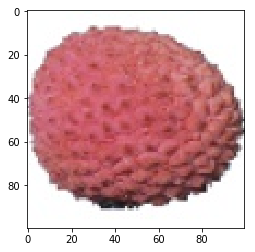

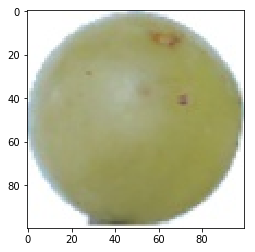

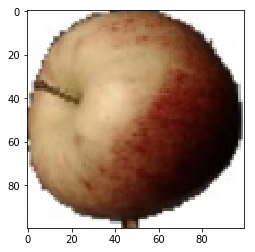

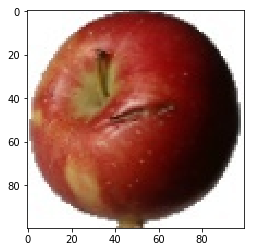

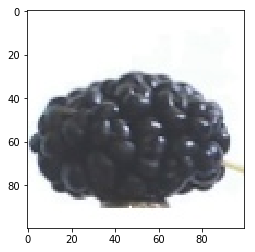

In [4]:
%matplotlib inline    
count = 0
for i in train_files:
    print(i[83:90])
    img = cv2.imread(i)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    count += 1
    if count == 5:
        break

In [5]:
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(100,100))
    x = image.img_to_array(img)
    return np.expand_dims(x,axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
train_data = preprocess_input(paths_to_tensor(train_files))
valid_data = preprocess_input(paths_to_tensor(valid_files))
test_data = preprocess_input(paths_to_tensor(test_files))
#multiple_test_data = preprocess_input(paths_to_tensor(multiple_test_files))
weights = "Data/Weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_xception = keras.applications.xception.Xception(include_top=False, weights=weights)

100%|██████████| 13877/13877 [00:05<00:00, 2392.48it/s]


In [7]:
np.savez("Output/FruitFeaturesXception.npz",train=model_xception.predict(train_data),valid=model_xception.predict(valid_data),\
         test=model_xception.predict(test_data))

In [8]:
bottleneck_features = np.load("Output/FruitFeaturesXception.npz")
train_xception = bottleneck_features['train']
valid_xception = bottleneck_features['valid']
test_xception = bottleneck_features['test']

In [9]:
my_model = Sequential()
my_model.add(GlobalAveragePooling2D(input_shape=train_xception.shape[1:]))
my_model.add(Dense(1032, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(81, activation='softmax'))

my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1032)              2114568   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1032)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               528896    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

In [10]:
my_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 50

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='Data/Weights/weights.best.xception.hdf5', 
                               verbose=1, save_best_only=True)

In [12]:
my_model.fit(train_xception, train_targets, 
          validation_data=(valid_xception, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 30269 samples, validate on 11053 samples
Epoch 1/50
30269/30269 [==============================] - 31s 1ms/step - loss: 0.7575 - acc: 0.7934 - val_loss: 0.1145 - val_acc: 0.9616

Epoch 00001: val_loss improved from inf to 0.11454, saving model to Data/Weights/weights.best.xception.hdf5
Epoch 2/50
30269/30269 [==============================] - 30s 988us/step - loss: 0.2864 - acc: 0.9336 - val_loss: 0.1135 - val_acc: 0.9715

Epoch 00002: val_loss improved from 0.11454 to 0.11355, saving model to Data/Weights/weights.best.xception.hdf5
Epoch 3/50
30269/30269 [==============================] - 30s 990us/step - loss: 0.2536 - acc: 0.9498 - val_loss: 0.1338 - val_acc: 0.9721

Epoch 00003: val_loss did not improve from 0.11355
Epoch 4/50
30269/30269 [==============================] - 30s 992us/step - loss: 0.2578 - acc: 0.9582 - val_loss: 0.0871 - val_acc: 0.9828

Epoch 00004: val_loss improved from 0.11355 to 0.08708, saving model to Data/Weights/weights.best.xception.hdf5
Epoch 5/5

In [13]:
my_model.load_weights('Data/Weights/weights.best.xception.hdf5')

In [14]:
predictions = [np.argmax(my_model.predict(np.expand_dims(feature, axis=0))) for feature in test_xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy for xception: %.4f%%' % test_accuracy)

Test accuracy for xception: 94.5305%
